In [1]:
import numpy as np
import pandas as pd
import talib
import ta
from ta.trend import macd
import random
random.seed(42)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [2]:
# apple stock price değerleri
df = yf.download("AAPL",start="2018-01-01", end="2022-01-01")
dataset = df.dropna()
dataset = dataset[["Open", "High", "Low", "Close"]]
dataset

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999
2018-01-03,43.132500,43.637501,42.990002,43.057499
2018-01-04,43.134998,43.367500,43.020000,43.257500
2018-01-05,43.360001,43.842499,43.262501,43.750000
2018-01-08,43.587502,43.902500,43.482498,43.587502
...,...,...,...,...
2021-12-27,177.089996,180.419998,177.070007,180.330002
2021-12-28,180.160004,181.330002,178.529999,179.289993
2021-12-29,179.330002,180.630005,178.139999,179.380005


In [3]:
RSI = ta.momentum.RSIIndicator(dataset["Close"], window= 14, fillna = False)

In [4]:
dataset["Y-D"] = dataset["High"] - dataset["Low"]
dataset["A-K"] = dataset["Close"] - dataset["Open"]
dataset["SMA 30"] = dataset[["Close"]].rolling(30).mean().shift(1)
dataset["RSI"] = RSI.rsi()
dataset["MACD"] = macd(dataset["Close"], window_slow = 26, window_fast = 12)

In [5]:
dataset["Fiyat_Yükselmesi"] = np.where(dataset['Close'].shift(-1) > dataset['Close'], 1, 0)
dataset = dataset.dropna()

In [6]:
dataset.head(10)

,Open,High,Low,Close,Y-D,A-K,SMA 30,RSI,MACD,Fiyat_Yükselmesi
Date,,,,,,,,,,
2018-02-14,40.759998,41.884998,40.720001,41.842499,1.164997,1.082500,42.500500,50.595832,-0.765186,1
2018-02-15,42.447498,43.272499,42.250000,43.247501,1.022499,0.800003,42.459750,58.010221,-0.524671,0
2018-02-16,43.090000,43.705002,42.942501,43.107498,0.762501,0.017498,42.466083,57.090781,-0.341423,0
2018-02-20,43.012501,43.564999,42.855000,42.962502,0.709999,-0.049999,42.461083,56.099084,-0.205528,0
2018-02-21,43.207500,43.529999,42.752499,42.767502,0.777500,-0.439999,42.434833,54.722385,-0.112271,1
2018-02-22,42.950001,43.487499,42.927502,43.125000,0.559998,0.174999,42.407500,56.814776,-0.009409,1
2018-02-23,43.417500,43.912498,43.384998,43.875000,0.527500,0.457500,42.392250,60.897380,0.131117,1
2018-02-26,44.087502,44.847500,44.052502,44.742500,0.794998,0.654999,42.402333,65.016959,0.308925,0
2018-02-27,44.775002,45.119999,44.540001,44.597500,0.579998,-0.177502,42.433083,63.806920,0.433145,0


In [7]:
# train set'in yüzdesi
split = int(0.80*len(dataset))

# train setler
X_train = dataset[["Y-D", "A-K", "SMA 30", "RSI" , "MACD"]].iloc[:split]
y_train = dataset[["Fiyat_Yükselmesi"]].iloc[:split]


# test setler
X_test = dataset[["Y-D", "A-K", "SMA 30", "RSI" , "MACD"]].iloc[split:]
y_test = dataset[["Fiyat_Yükselmesi"]].iloc[split:]

In [8]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print(X_test, type(X_test[1][1]))

[[ 6.53218489e-01  7.88846696e-01  1.94442341e+00 -1.04194835e+00
  -1.43928667e+00]
 [ 5.85133558e-01  6.41815868e-01  1.92732283e+00 -9.43339200e-01
  -1.39575454e+00]
 [ 1.01718599e-01 -2.24917965e-01  1.91123904e+00 -9.13423404e-01
  -1.34249283e+00]
 [-1.09346247e-01 -1.86222223e-01  1.89508593e+00 -1.12041999e+00
  -1.35583301e+00]
 [ 4.55763358e-01  3.63223061e-01  1.87973008e+00 -7.32731998e-01
  -1.25633344e+00]
 [-7.21625246e-03 -5.34466184e-01  1.86968927e+00 -5.93839034e-01
  -1.13127622e+00]
 [ 9.45988368e-01  1.54723954e+00  1.86193623e+00 -1.56608146e-01
  -8.97250959e-01]
 [-1.50201361e-01 -2.48133048e-01  1.85734912e+00 -1.12513102e-01
  -6.94692842e-01]
 [ 7.34918328e-01  1.57819495e+00  1.85759177e+00  1.25200847e-01
  -4.58262676e-01]
 [ 1.15333507e-01  1.06744541e+00  1.85994887e+00  4.37587644e-01
  -1.64045518e-01]
 [ 1.27279292e+00  2.45266321e+00  1.86573765e+00  7.29658986e-01
   1.80028322e-01]
 [ 3.53638558e-01 -1.01426031e+00  1.87961454e+00  3.77935165e-01

In [11]:
classifier = Sequential()
classifier.add(Dense(units = 50, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train.shape[1]))
classifier.add(Dense(units = 25, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
classifier.fit(X_train, y_train, batch_size = 10, epochs = 500)

Epoch 1/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2498 - accuracy: 0.5384
Epoch 2/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2492 - accuracy: 0.5384
Epoch 3/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2484 - accuracy: 0.5384
Epoch 4/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2479 - accuracy: 0.5384
Epoch 5/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2474 - accuracy: 0.5384
Epoch 6/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2471 - accuracy: 0.5371
Epoch 7/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2468 - accuracy: 0.5563
Epoch 8/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2469 - accuracy: 0.5614
Epoch 9/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2464 - accuracy: 0.5575
Epoch 10/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2459 - accuracy: 0.5665
Epoch 11/

79/79 [==============================] - 0s 1ms/step - loss: 0.2309 - accuracy: 0.6087
Epoch 84/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2307 - accuracy: 0.6113
Epoch 85/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2312 - accuracy: 0.6087
Epoch 86/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2303 - accuracy: 0.6125
Epoch 87/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2293 - accuracy: 0.6087
Epoch 88/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2300 - accuracy: 0.6100
Epoch 89/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2298 - accuracy: 0.6087
Epoch 90/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2283 - accuracy: 0.6164
Epoch 91/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2284 - accuracy: 0.6113
Epoch 92/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2282 - accuracy: 0.6125
Epoch 93/500


79/79 [==============================] - 0s 1ms/step - loss: 0.2131 - accuracy: 0.6509
Epoch 165/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2101 - accuracy: 0.6739
Epoch 166/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2097 - accuracy: 0.6624
Epoch 167/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2099 - accuracy: 0.6777
Epoch 168/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2103 - accuracy: 0.6560
Epoch 169/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2130 - accuracy: 0.6547
Epoch 170/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2098 - accuracy: 0.6535
Epoch 171/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2096 - accuracy: 0.6714
Epoch 172/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2122 - accuracy: 0.6637
Epoch 173/500
79/79 [==============================] - 0s 1ms/step - loss: 0.2090 - accuracy: 0.6752
Epoc

79/79 [==============================] - 0s 1ms/step - loss: 0.1951 - accuracy: 0.7008
Epoch 246/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1951 - accuracy: 0.7020
Epoch 247/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1953 - accuracy: 0.6905
Epoch 248/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1932 - accuracy: 0.7148
Epoch 249/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1934 - accuracy: 0.7072
Epoch 250/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1965 - accuracy: 0.6918
Epoch 251/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1976 - accuracy: 0.6982
Epoch 252/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1962 - accuracy: 0.7033
Epoch 253/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1942 - accuracy: 0.7033
Epoch 254/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1924 - accuracy: 0.7059
Epoc

79/79 [==============================] - 0s 1ms/step - loss: 0.1819 - accuracy: 0.7212
Epoch 327/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1799 - accuracy: 0.7315
Epoch 328/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1872 - accuracy: 0.7276
Epoch 329/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1856 - accuracy: 0.7199
Epoch 330/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1804 - accuracy: 0.7353
Epoch 331/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1824 - accuracy: 0.7148
Epoch 332/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1787 - accuracy: 0.7430
Epoch 333/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1794 - accuracy: 0.7212
Epoch 334/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1779 - accuracy: 0.7379
Epoch 335/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1780 - accuracy: 0.7327
Epoc

79/79 [==============================] - 0s 1ms/step - loss: 0.1717 - accuracy: 0.7417
Epoch 408/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1674 - accuracy: 0.7621
Epoch 409/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1666 - accuracy: 0.7519
Epoch 410/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1738 - accuracy: 0.7263
Epoch 411/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1631 - accuracy: 0.7698
Epoch 412/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1693 - accuracy: 0.7417
Epoch 413/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1658 - accuracy: 0.7506
Epoch 414/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1689 - accuracy: 0.7468
Epoch 415/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1679 - accuracy: 0.7468
Epoch 416/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1685 - accuracy: 0.7621
Epoc

79/79 [==============================] - 0s 1ms/step - loss: 0.1571 - accuracy: 0.7762
Epoch 489/500
79/79 [==============================] - 0s 2ms/step - loss: 0.1511 - accuracy: 0.7954
Epoch 490/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1567 - accuracy: 0.7737
Epoch 491/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1521 - accuracy: 0.7762
Epoch 492/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1517 - accuracy: 0.7980
Epoch 493/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1543 - accuracy: 0.8005
Epoch 494/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1591 - accuracy: 0.7788
Epoch 495/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1509 - accuracy: 0.7813
Epoch 496/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1541 - accuracy: 0.7685
Epoch 497/500
79/79 [==============================] - 0s 1ms/step - loss: 0.1576 - accuracy: 0.7775
Epoc

In [12]:
y_tahmin = classifier.predict(X_test)
y_tahmin = (y_tahmin > 0.5)

In [13]:
dataset["y_tahmin"] = np.NaN
dataset.iloc[(len(dataset) - len(y_tahmin)):,-1:] = y_tahmin
ticaret_dataset = dataset.dropna()
ticaret_dataset.head(10)

,Open,High,Low,Close,Y-D,A-K,SMA 30,RSI,MACD,Fiyat_Yükselmesi,y_tahmin
Date,,,,,,,,,,,
2021-03-25,119.540001,121.660004,119.000000,120.589996,2.660004,1.049995,124.892000,43.713713,-1.860506,1,True
2021-03-26,120.349998,121.480003,118.919998,121.209999,2.560005,0.860001,124.398666,44.995053,-1.781730,1,True
2021-03-29,121.650002,122.580002,120.730003,121.389999,1.849998,-0.260002,123.934666,45.383782,-1.685347,0,False
2021-03-30,120.110001,120.400002,118.860001,119.900002,1.540001,-0.209999,123.468666,42.694043,-1.709488,1,True
2021-03-31,121.650002,123.519997,121.150002,122.150002,2.369995,0.500000,123.025666,47.731709,-1.529433,1,True
2021-04-01,123.660004,124.180000,122.489998,123.000000,1.690002,-0.660004,122.736000,49.536501,-1.303128,1,True
2021-04-05,123.870003,126.160004,123.070000,125.900002,3.090004,2.029999,122.512333,55.217934,-0.879635,1,False
2021-04-06,126.500000,127.129997,125.650002,126.209999,1.479996,-0.290001,122.380000,55.790910,-0.513084,1,True
2021-04-07,125.830002,127.919998,125.139999,127.900002,2.779999,2.070000,122.387000,58.879795,-0.085239,1,False


In [14]:
ticaret_dataset["Ertesi Gün"] = 0.
ticaret_dataset["Ertesi Gün"] = np.log(ticaret_dataset["Close"]/ticaret_dataset["Close"].shift(1))
ticaret_dataset["Ertesi Gün"] = ticaret_dataset["Ertesi Gün"].shift(-1)
ticaret_dataset

,Open,High,Low,Close,Y-D,A-K,SMA 30,RSI,MACD,Fiyat_Yükselmesi,y_tahmin,Ertesi Gün
Date,,,,,,,,,,,,
2021-03-25,119.540001,121.660004,119.000000,120.589996,2.660004,1.049995,124.892000,43.713713,-1.860506,1,True,0.005128
2021-03-26,120.349998,121.480003,118.919998,121.209999,2.560005,0.860001,124.398666,44.995053,-1.781730,1,True,0.001484
2021-03-29,121.650002,122.580002,120.730003,121.389999,1.849998,-0.260002,123.934666,45.383782,-1.685347,0,False,-0.012350
2021-03-30,120.110001,120.400002,118.860001,119.900002,1.540001,-0.209999,123.468666,42.694043,-1.709488,1,True,0.018592
2021-03-31,121.650002,123.519997,121.150002,122.150002,2.369995,0.500000,123.025666,47.731709,-1.529433,1,True,0.006935
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,177.089996,180.419998,177.070007,180.330002,3.349991,3.240005,165.362667,66.890408,5.051209,0,False,-0.005784
2021-12-28,180.160004,181.330002,178.529999,179.289993,2.800003,-0.870010,166.444668,64.950263,5.102919,1,False,0.000502
2021-12-29,179.330002,180.630005,178.139999,179.380005,2.490005,0.050003,167.421334,65.044762,5.092459,0,False,-0.006600


In [15]:
ticaret_dataset["Strateji Çıktısı"] = 0.
ticaret_dataset["Strateji Çıktısı"] = np.where(ticaret_dataset["y_tahmin"] == True, 
                                               ticaret_dataset["Ertesi Gün"], - ticaret_dataset["Ertesi Gün"])
ticaret_dataset.head()

,Open,High,Low,Close,Y-D,A-K,SMA 30,RSI,MACD,Fiyat_Yükselmesi,y_tahmin,Ertesi Gün,Strateji Çıktısı
Date,,,,,,,,,,,,,
2021-03-25,119.540001,121.660004,119.000000,120.589996,2.660004,1.049995,124.892000,43.713713,-1.860506,1,True,0.005128,0.005128
2021-03-26,120.349998,121.480003,118.919998,121.209999,2.560005,0.860001,124.398666,44.995053,-1.781730,1,True,0.001484,0.001484
2021-03-29,121.650002,122.580002,120.730003,121.389999,1.849998,-0.260002,123.934666,45.383782,-1.685347,0,False,-0.012350,0.012350
2021-03-30,120.110001,120.400002,118.860001,119.900002,1.540001,-0.209999,123.468666,42.694043,-1.709488,1,True,0.018592,0.018592
2021-03-31,121.650002,123.519997,121.150002,122.150002,2.369995,0.500000,123.025666,47.731709,-1.529433,1,True,0.006935,0.006935


In [16]:
ticaret_dataset["Kümülatif Market Çıktısı"] = np.cumsum(ticaret_dataset["Ertesi Gün"]*100)
ticaret_dataset["Kümülatif Strateji Çıktısı"] = np.cumsum(ticaret_dataset["Strateji Çıktısı"]*100)
ticaret_dataset.head()

,Open,High,Low,Close,Y-D,A-K,SMA 30,RSI,MACD,Fiyat_Yükselmesi,y_tahmin,Ertesi Gün,Strateji Çıktısı,Kümülatif Market Çıktısı,Kümülatif Strateji Çıktısı
Date,,,,,,,,,,,,,,,
2021-03-25,119.540001,121.660004,119.000000,120.589996,2.660004,1.049995,124.892000,43.713713,-1.860506,1,True,0.005128,0.005128,0.512824,0.512824
2021-03-26,120.349998,121.480003,118.919998,121.209999,2.560005,0.860001,124.398666,44.995053,-1.781730,1,True,0.001484,0.001484,0.661217,0.661217
2021-03-29,121.650002,122.580002,120.730003,121.389999,1.849998,-0.260002,123.934666,45.383782,-1.685347,0,False,-0.012350,0.012350,-0.573826,1.896259
2021-03-30,120.110001,120.400002,118.860001,119.900002,1.540001,-0.209999,123.468666,42.694043,-1.709488,1,True,0.018592,0.018592,1.285348,3.755432
2021-03-31,121.650002,123.519997,121.150002,122.150002,2.369995,0.500000,123.025666,47.731709,-1.529433,1,True,0.006935,0.006935,1.978802,4.448887


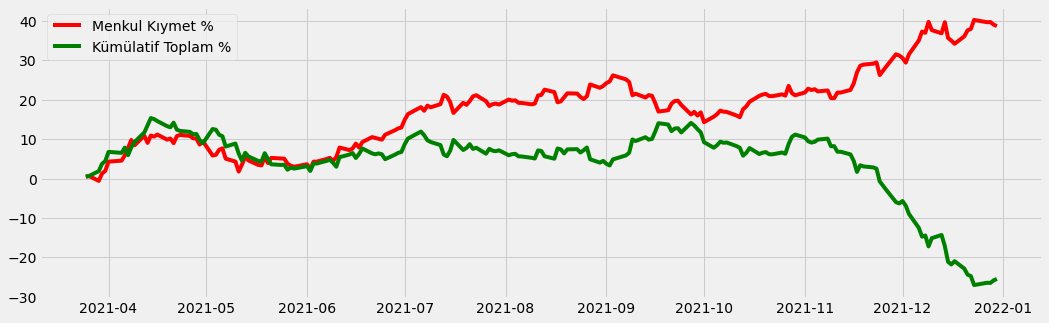

In [17]:
plt.figure(figsize=(16,5))
plt.plot(ticaret_dataset["Kümülatif Market Çıktısı"], color='r', label="Menkul Kıymet %")
plt.plot(ticaret_dataset["Kümülatif Strateji Çıktısı"], color='g', label="Kümülatif Toplam %")
plt.legend()
plt.show()

In [18]:
return_serie = ticaret_dataset["Strateji Çıktısı"].pct_change(1).dropna()
return_serie.name = "return"

# sortino hesapla
mean = np.mean(return_serie) #252
vol = np.std(return_serie[return_serie<0]) #sqrt(252)
sortino = np.sqrt(252) * mean/vol

print(f"Sortino: {'%.3f' % sortino}")
"""
sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
sp500.name = "SP500"

# alınan verileri birleştir
val = pd.concat((return_serie, sp500), axis=1).dropna()

# beta yı hesapla
cov_var_mat = np.cov(val.values, rowvar=False)
cov = cov_var_mat[0][1]
var = cov_var_mat[1][1]

beta = cov/var

print(f"Beta: {'%.3f' % beta}")

#alphayı hesapla
alpha = (252 * mean * (1-beta))*100
print(f"Alpha: {'%.1f' % alpha}")
"""

Sortino: -2.438


'\nsp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)\nsp500.name = "SP500"\n\n# alınan verileri birleştir\nval = pd.concat((return_serie, sp500), axis=1).dropna()\n\n# beta yı hesapla\ncov_var_mat = np.cov(val.values, rowvar=False)\ncov = cov_var_mat[0][1]\nvar = cov_var_mat[1][1]\n\nbeta = cov/var\n\nprint(f"Beta: {\'%.3f\' % beta}")\n\n#alphayı hesapla\nalpha = (252 * mean * (1-beta))*100\nprint(f"Alpha: {\'%.1f\' % alpha}")\n'

In [19]:
def drawdown_function(serie):

  # cumulitve sum hesapla
  cum = serie.dropna().cumsum() + 1

  # periyottaki maksimim cumsum hesapla - maksimum birikim 
  running_max = np.maximum.accumulate(cum)

  # drawdown hesapla
  drawdown = cum/running_max - 1
  return drawdown

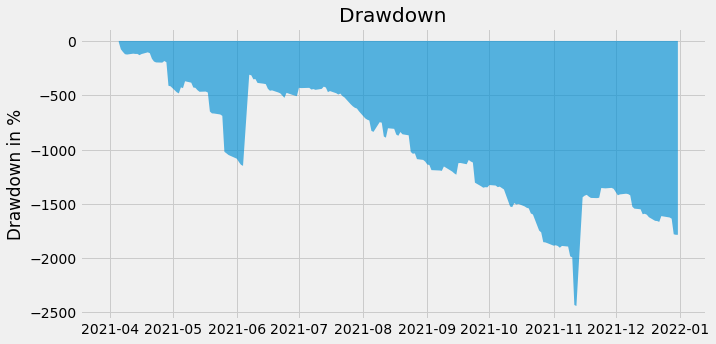

Max drawdown: 2442.2 %


In [20]:
# drawdawn döndür
drawdown = drawdown_function(return_serie)

plt.figure(figsize=(10,5))
plt.fill_between(drawdown.index, drawdown*100, 0, drawdown, alpha=0.65)
plt.title("Drawdown")
plt.ylabel("Drawdown in %")
plt.show()

max_drawdown = -np.min(drawdown)*100
print(f"Max drawdown: {'%.1f' % max_drawdown} %")

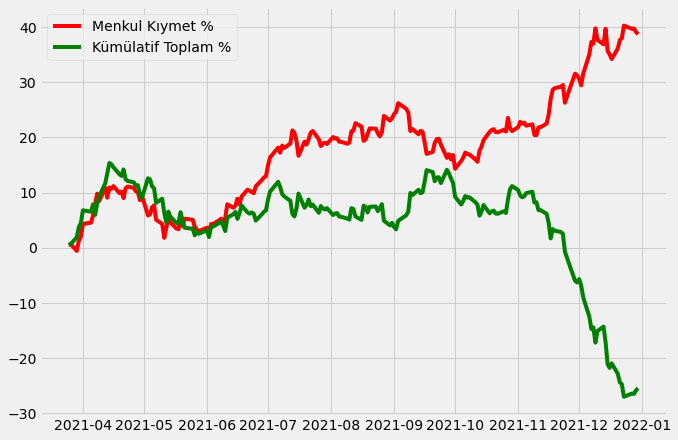

Sortino: -2.438
Maksimum Düşüş: 2442.2 %


In [21]:
plt.figure(figsize=(10,7))
plt.plot(ticaret_dataset["Kümülatif Market Çıktısı"], color='r', label="Menkul Kıymet %")
plt.plot(ticaret_dataset["Kümülatif Strateji Çıktısı"], color='g', label="Kümülatif Toplam %")
plt.legend()
plt.show()

print(f"Sortino: {'%.3f' % sortino}")
print(f"Maksimum Düşüş: {'%.1f' % max_drawdown} %")